In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Phân tích quan hệ giữa chỉ số AQI và các yếu tố môi trường

Bản phân tích nhanh dưới đây được thực hiện dựa trên data cung cấp bởi anh Đàm Quang Minh, đến ngày 6/5/2020 tại điểm quan trắc Trường đại học Phú Xuân (Huế).

## 1. Mô tả data

- Data gồm 8 chỉ số và hàm lượng sau: AQI US, AQI CN, PM2.5, PM10, CO2, Nhiệt độ (C), Nhiệt độ (F), Độ ẩm.

- Data được thu thập theo giờ từ ngày 2/1/2019 đến ngày 6/5/2020.

Một phần nhỏ của data được trình bày trong bảng sau:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/nhohung/datasciencecoursera/master/historical_hourly_data_GLRT9TR.csv', parse_dates=True)

In [4]:
df = df.iloc[:,1:10]
df.Datetime = pd.to_datetime(df.Datetime)
df.set_index('Datetime', inplace = True)

In [5]:
df.head()

,AQI US,AQI CN,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
Datetime,,,,,,,,
2020-05-06 09:00:00,152,79,58,88,437.3,31.8,89.3,74.0
2020-05-06 08:00:00,153,80,59,87,445.8,30.4,86.7,78.8
2020-05-06 07:00:00,153,80,59,84,467.2,28.4,83.1,84.4
2020-05-06 06:00:00,152,77,57,73,492.0,26.9,80.4,88.3
2020-05-06 05:00:00,157,90,67,86,492.6,27.2,80.9,87.0


## 2. Phân tích trực quan sơ bộ

Trước tiên chúng ta quan sát phân bố tương quan giữa các cặp thông số:

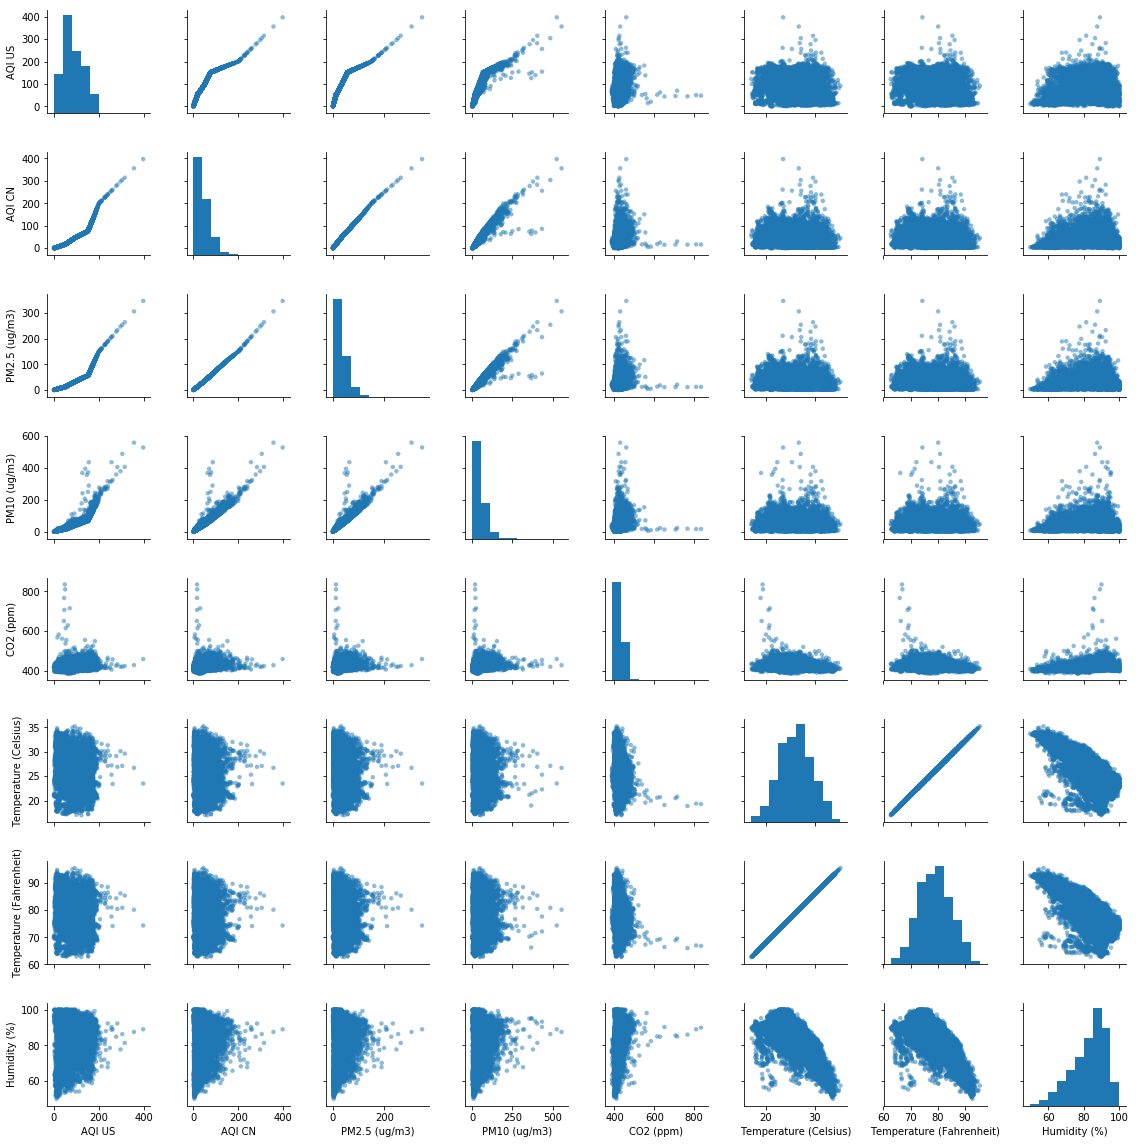

In [5]:
sns.pairplot(df, height=2, markers=".",
            plot_kws={'s':80, 'edgecolor':'none', 'alpha':0.5})

### Nhận xét:

- Hai chỉ số AQI CN và AQI US có tương quan tuyến tính theo từng khoảng, và hoàn toàn bằng nhau với giá trị trên 200. Để xem giải thích chi tiết, xin mời vào địa chỉ [này](https://support.airvisual.com/en/articles/3029421-what-is-the-difference-between-china-us-aqi-%E7%BE%8E%E5%9B%BD%E7%A9%BA%E6%B0%94%E8%B4%A8%E9%87%8F%E6%8C%87%E6%95%B0%E5%92%8C%E4%B8%AD%E5%9B%BD%E7%A9%BA%E6%B0%94%E8%B4%A8%E9%87%8F%E6%8C%87%E6%95%B0%E6%9C%89%E4%BB%80%E4%B9%88%E5%8C%BA%E5%88%AB)
- Chỉ số nhiệt độ theo độ C và độ F hoàn toàn tương quan. Thông số độ F sẽ được bỏ đi cho các phân tích ở dưới.
- Hàm lượng PM 2.5 và PM10 có tương quan cao với cả 2 chỉ số AQI. PM 2.5 đặc biệt tuyến tính với AQI CN. PM10 có vài điểm ngoài khoảng thông dụng (outliers).
- Có biểu hiện tuyến tính yếu giữa nhiệt độ và độ ẩm
- Hàm lượng CO2, nhiệt độ và độ ẩm không quan sát thấy tương quan với các chỉ số AQI.

## 3. Phân tích tương quan AQI theo thời gian

### 3.1. Ngày trong tuần

Có nhiều ý kiến cho rằng mức độ ô nhiễm bụi mịn và AQI sẽ cao hơn vào các ngày trong tuần khi người dân sử dụng phương tiện giao thông nhiều hơn cuối tuần. Tuy nhiên, biểu diễn thống kê cho thấy không có sự khác biệt đó:

In [6]:
df['Weekday'] = df.index.weekday_name

In [8]:
t = df[['AQI CN', 'PM10 (ug/m3)', 'CO2 (ppm)', 'Weekday']]
t.loc[(t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday'), 'isweekend'] = 'Trong tuần' 
t.loc[~((t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday')), 'isweekend'] = 'Cuối tuần' 

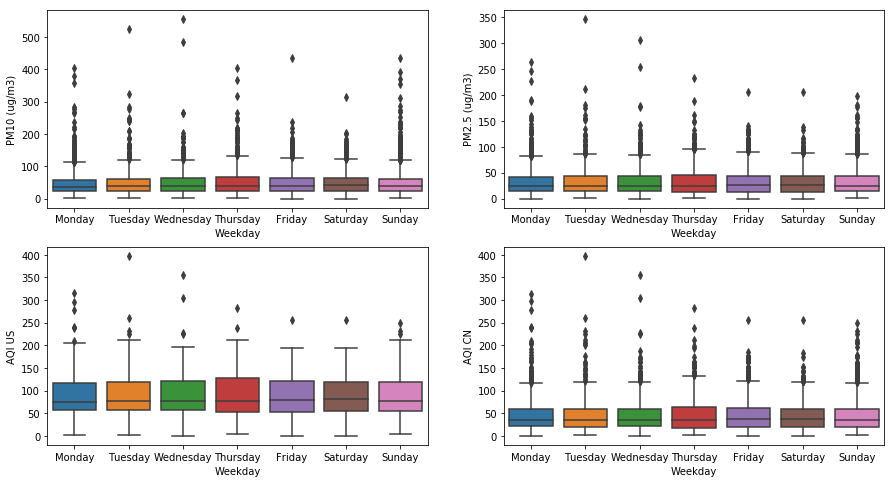

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
sns.boxplot(x="Weekday", y="PM10 (ug/m3)", data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
           ax=axs[0,0])
sns.boxplot(x="Weekday", y="PM2.5 (ug/m3)", data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
           ax=axs[0,1])
sns.boxplot(x="Weekday", y="AQI US", data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
           ax=axs[1,0])
sns.boxplot(x="Weekday", y="AQI CN", data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
           ax=axs[1,1])
# sns.regplot(x='value', y='wage', data=df_melt, ax=axs[0])
# sns.regplot(x='value', y='wage', data=df_melt, ax=axs[1])

# fig, ax = plt.subplots(nrows=2, ncols=2)

# ax[0,0] = sns.boxplot(x="Weekday", y="PM10 (ug/m3)", data=df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
# # plt.ylim([400,500])
# ax[0,0].set(ylim = (0,100))

# ax[0,1] = sns.boxplot(x="Weekday", y="PM10 (ug/m3)", data=df,
#                  order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
# # plt.ylim([400,500])
# ax[0,1].set(ylim = (0,100))

# ax[1,0] = sns.boxplot(x="Weekday", y="PM10 (ug/m3)", data=df,
#                  order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
# # plt.ylim([400,500])
# ax[1,0].set(ylim = (0,100))

# ax[1,1] = sns.boxplot(x="Weekday", y="PM10 (ug/m3)", data=df,
#                  order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
# # plt.ylim([400,500])
# ax[1,1].set(ylim = (0,100))


### 3.2. Giờ trong ngày

Ý kiến về ô nhiễm không khí do giao thông của người dân có thể được kiểm chứng khi biểu diễn dữ liệu theo khung giờ. Ví dụ dưới đây thể hiện diễn biến AQI và bụi mịn trung bình (biểu đồ tập trung quanh giá trị trung bình).

In [24]:
df['Hour'] = df.index.hour

In [40]:
t = df[['AQI CN', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'CO2 (ppm)', 'Weekday', 'Hour', 'Temperature (Celsius)']]
t.loc[(t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday'), 'isweekend'] = 'Trong tuần' 
t.loc[~((t['Weekday'] == 'Saturday')|(t['Weekday'] == 'Sunday')), 'isweekend'] = 'Cuối tuần' 

In [41]:
df_wd = t[t.isweekend=='Trong tuần']
df_wk = t[t.isweekend=='Cuối tuần']

[(0, 60)]

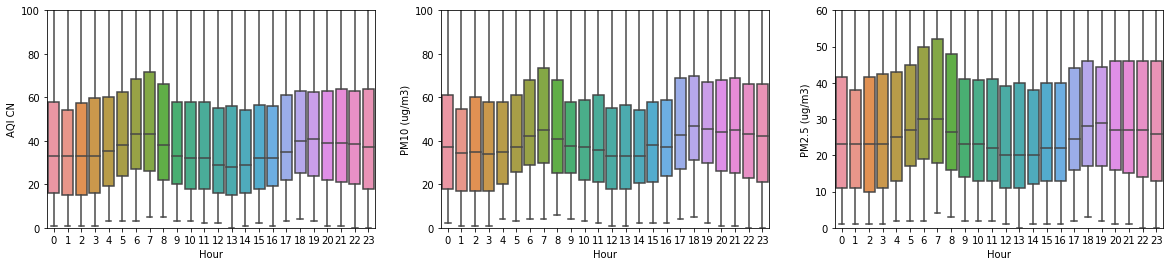

In [44]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
sns.boxplot(x="Hour", y="AQI CN", data=df_wk,
           ax=axs[0])
sns.boxplot(x="Hour", y="PM10 (ug/m3)", data=df_wk,
           ax=axs[1])
sns.boxplot(x="Hour", y="PM2.5 (ug/m3)", data=df_wk,
           ax=axs[2])
axs[0].set(ylim = (0,100))
axs[1].set(ylim = (0,100))
axs[2].set(ylim = (0,60))

Có thể thấy rất rõ các chỉ số bụi mịn và chất lượng không khí tăng cao vào giờ cao điểm đi làm (7h sáng) và giờ người dân tham gia các hoạt động ngoài trời cuối ngày (sau 6h tối).

Một lần nữa, khi quan sát dữ liệu theo giờ, kết quả vẫn không cho thấy sự khác biệt giữa ngày trong tuần và cuối tuần:

(350, 500)

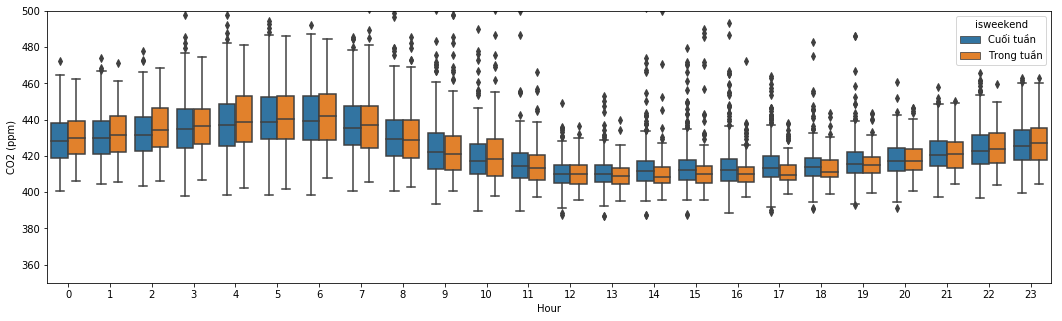

In [45]:
fig, ax = plt.subplots(figsize=(18,5))
ax = sns.boxplot(x="Hour", y="CO2 (ppm)", data=t, hue='isweekend')
plt.ylim([350,500])
# plt.ylim([0,100])

### 3.3. Phân tích tuyến tính

Ở phần này, chúng ta xây dựng nhanh một mô hình tương quan tuyến tính tiêu chuẩn (ordinary least squares regression) để tìm mối liên hệ định lượng giữa chỉ số AQI CN và các thông số môi trường khác. Các thông số môi trường này được chuẩn hoá về giá trị [0-1] trước khi đưa vào mô hình.

In [46]:
X = df[['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'CO2 (ppm)', 'Temperature (Celsius)', 'Humidity (%)']]
Y1 = df['AQI US']
Y2 = df['AQI CN']

In [47]:
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [49]:
x = X.values
# normalized_x = preprocessing.normalize(x)
normalized_x = preprocessing.MinMaxScaler().fit_transform(x)
normalized_X = pd.DataFrame(normalized_x)
normalized_X.columns = X.columns
normalized_X.set_index(X.index, inplace = True)

In [50]:
X1 = sm.add_constant(normalized_X) # adding a constant
 
model = sm.OLS(Y2, X1).fit()
predictions = model.predict(X1) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 AQI CN   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 9.596e+05
Date:                Thu, 07 May 2020   Prob (F-statistic):               0.00
Time:                        00:37:47   Log-Likelihood:                -20466.
No. Observations:               11012   AIC:                         4.094e+04
Df Residuals:                   11006   BIC:                         4.099e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.66

/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Kết quả thống kê này phù hợp với kết quả phân tích định tính từ biểu đồ đã trình bày ở 2 phần trên. Sau đây là một số điểm kết luận chính:

- Mô hình tuyến tính xấp xỉ rất tốt chỉ số AQI CN với giá trị R2 cao.
- Sau khi chuẩn hoá giá trị các biến, bảng hệ số cho thấy PM2.5 có tương quan cao nhất với AQI. Các chỉ số PM10, Nhiệt độ và Độ ẩm tuy có  nghĩa thống kê nhưng độ ảnh hưởng thấp hơn nhiều so với PM 2.5.
- Hàm lượng CO2 có ảnh hưởng thấp nhất với P-value lớn hơn độ tin cậy 0.05. Về mặt ý nghĩa thống kê, CO2 không có tương quan với AQI.

## 4. Kết luận

- Kết quả phân tích trực quan cho thấy các chỉ số không khí (AQI) và môi trường (PM) thay đổi có trật tự theo thời gian trong ngày. Một lý do giải thích cho hiện tượng này là hoạt động của người dân.

- Kết quả phân tích trực quan định tính và xây dựng mô hình tuyến tính định lượng cho thấy hàm lượng bụi mịn PM 2.5 và PM 10 có tương quan cao nhất với chỉ số chất lượng không khí AQI CN. Ngược lại, hàm lượng CO2 không có ý nghĩa thống kê trong tương quan với AQI.

- Xin lưu ý, về mặt thống kê, chúng ta chỉ có thể kết luận AQI và PM 2.5 có tương quan cao. Tuy nhiên, dựa trên nguyên tắc tính AQI (link tham khảo ở mục 2 bên trên), chỉ số này có liên quan trực tiếp đến PM 2.5. Vì vậy, về bản chất, 2 đại lượng này phụ thuộc tuyến tính với nhau.